In [1]:
import numpy as np
import matplotlib.pyplot as plt

import spikeinterface.extractors as se
import spikeinterface.sorters as ss
# import spikeinterface.comparison as sc
import spikeinterface.exporters as sexp
import spikeinterface.widgets as sw
import spikeinterface.full as si
import probeinterface as pi
import spikeinterface_gui
from phy.apps.template import template_gui

import os
import time
from pathlib import Path

C:\Users\lwood39\.conda\envs\spikesort\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
C:\Users\lwood39\.conda\envs\spikesort\lib\site-packages\phy\utils\plugin.py:14: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [3]:
# path_to_folder = Path('G:/VNCMP/2022_11_16/intan/moth0_1_221116_154712')
# dircontents = os.listdir(path_to_folder)
# file_names = [x for x in dircontents if '.rhd' in x]
# recording_list = []
# for file in file_names:
#     path_to_file = os.path.join(path_to_folder, file)
#     recording_list.append(se.IntanRecordingExtractor(path_to_file, stream_id='0'))
# recording = si.concatenate_recordings(recording_list)

# path_to_folder = Path('G:/VNCMP/2023-02-28_13-55-21/Record Node 103')
path_to_folder = Path('G:/VNCMP/20230308/2023-03-08_13-08-30/Record Node 104')
recording = se.read_openephys(path_to_folder, block_index=0, stream_id='0')
recording = si.SelectSegmentRecording(recording, 0)

In [4]:
# Remove analog input channels if present, not needed for spike sorting
if any('ADC' in s for s in recording.get_channel_ids()):  
    recording = recording.remove_channels([x for x in recording.get_channel_ids() if 'ADC' in x])
recording.get_channel_ids()

array(['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8', 'CH9',
       'CH10', 'CH11', 'CH12', 'CH13', 'CH14', 'CH15', 'CH16', 'CH17',
       'CH18', 'CH19', 'CH20', 'CH21', 'CH22', 'CH23', 'CH24', 'CH25',
       'CH26', 'CH27', 'CH28', 'CH29', 'CH30', 'CH31', 'CH32'],
      dtype='<U64')

ChannelSliceRecording: 32 channels - 1 segments - 30.0kHz - 397.761s

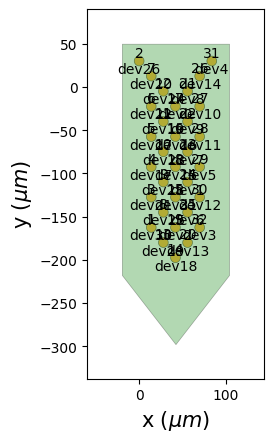

In [17]:
probe = pi.read_probeinterface('A32_A1x32-Poly5-6mm-35s-100.json')
pi.plotting.plot_probe_group(probe, with_channel_index=True, with_device_index=True)
# recording.set_probegroup(probe)
recording.set_probe(probe.probes[0], in_place=True)

In [19]:
recording_f = si.bandpass_filter(recording, freq_min=300, freq_max=14000)
recording_cmr = si.common_reference(recording_f, reference='global', operator='median')
recording_cache_preprocessed = recording_cmr.save(format='binary')
recording_cache_raw = recording.save(format='binary')

Use cache_folder=C:\Users\lwood39\AppData\Local\Temp\spikeinterface_cache\tmpmwm_tlsa\SQHP9RTX
write_binary_recording with n_jobs = 1 and chunk_size = None
slice(None, None, None)
Use cache_folder=C:\Users\lwood39\AppData\Local\Temp\spikeinterface_cache\tmpoilc94xt\JG59G842
write_binary_recording with n_jobs = 1 and chunk_size = None
slice(None, None, None)


In [ ]:
sw.plot_timeseries(recording, time_range=(0,50), channel_ids=['CH1'])

In [ ]:
si.available_sorters()

## Kilosort

In [20]:
print(ss.Kilosort3Sorter.default_params())
ss.Kilosort3Sorter.params_description()

{'detect_threshold': 6, 'projection_threshold': [9, 9], 'preclust_threshold': 8, 'car': True, 'minFR': 0.2, 'minfr_goodchannels': 0.2, 'nblocks': 5, 'sig': 20, 'freq_min': 300, 'sigmaMask': 30, 'nPCs': 3, 'ntbuff': 64, 'nfilt_factor': 4, 'do_correction': True, 'NT': None, 'wave_length': 61, 'keep_good_only': False, 'n_jobs': 1, 'total_memory': None, 'chunk_size': None, 'chunk_memory': None, 'chunk_duration': '1s', 'progress_bar': True}


{'detect_threshold': 'Threshold for spike detection',
 'projection_threshold': 'Threshold on projections',
 'preclust_threshold': 'Threshold crossings for pre-clustering (in PCA projection space)',
 'car': 'Enable or disable common reference',
 'minFR': 'Minimum spike rate (Hz), if a cluster falls below this for too long it gets removed',
 'minfr_goodchannels': "Minimum firing rate on a 'good' channel",
 'nblocks': "blocks for registration. 0 turns it off, 1 does rigid registration. Replaces 'datashift' option.",
 'sig': 'spatial smoothness constant for registration',
 'freq_min': 'High-pass filter cutoff frequency',
 'sigmaMask': 'Spatial constant in um for computing residual variance of spike',
 'nPCs': 'Number of PCA dimensions',
 'ntbuff': 'Samples of symmetrical buffer for whitening and spike detection',
 'nfilt_factor': 'Max number of clusters per good channel (even temporary ones) 4',
 'do_correction': 'If True drift registration is applied',
 'NT': 'Batch size (if None it is au

In [21]:
default_ks_params = ss.Kilosort3Sorter.default_params()
default_ks_params['projection_threshold'] = [10, 4]
default_ks_params['preclust_threshold'] = 8
default_ks_params['minFR'] = 0.1
default_ks_params['minfr_goodchannels'] = 0.1
# default_ks_params['freq_min'] = 300
default_ks_params['keep_good_only'] = True
# default_ks_params['car'] = False
tic = time.perf_counter()
sort_ks = ss.run_kilosort3(
    recording=recording_cache_raw,
    output_folder="kilosort3",
    docker_image="spikeinterface/kilosort3-compiled-base",
    verbose=True,
    **default_ks_params)
print(f'{time.perf_counter()-tic} seconds elapsed')

print(sort_ks)

Starting container
Installing spikeinterface==0.96.1 in spikeinterface/kilosort3-compiled-base
Installing extra requirements: ['neo']
Running kilosort3 sorter inside spikeinterface/kilosort3-compiled-base
Stopping container
403.3721444999683 seconds elapsed
KiloSortSortingExtractor: 88 units - 1 segments - 30.0kHz


In [22]:
wave_extract = si.extract_waveforms(
    recording_cache_preprocessed, sort_ks, './waveforms',
    ms_before=2., ms_after=2.,
    overwrite=True, 
    n_jobs=8, chunk_size=30000)
pc = si.compute_principal_components(wave_extract, n_components=4, mode='by_channel_local', whiten=True)

## Phy GUI

In [ ]:
# sexp.export_to_phy(wave_extract, 
#                    './phy_folder_kilosort', 
#                    remove_if_exists=True,
#                    n_jobs=8, chunk_size=30000)
os.chdir(Path('C:/Users/lwood39/Documents/AutoSpikeSort/phy_folder_kilosort'))
template_gui('params.py')

## Spikeinterface GUI

In [12]:
os.chdir(Path('C:/Users/lwood39/Documents/AutoSpikeSort/'))
app = spikeinterface_gui.mkQApp()
win = spikeinterface_gui.MainWindow(wave_extract)
win.show()
app.exec()

0